In [1]:
import numpy as np
import pandas as pd

In [2]:
import cufflinks as cf
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
import IPython

IPython.get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

In [3]:
df = pd.read_csv("data/AirPassengers.csv")
df['Month'] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df = df.set_index(['Month'])
df.head()


,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.iplot(xTitle="Date", yTitle="Passengers")

## Test if stationary

In [ ]:
rollmean = df.rolling(window=12).mean()
rollstd = df.rolling(window=12).std()


In [ ]:
from plotly import graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pd.to_datetime(rollmean.index.values),
    y=rollmean['#Passengers'],
    name='mean',mode='lines'))

fig.add_trace(go.Scatter(
    x=pd.to_datetime(rollmean.index.values),
    y=rollstd['#Passengers'],
    name='std',mode='lines'))


fig.add_trace(go.Scatter(
    x=pd.to_datetime(df.index.values),
    y=df['#Passengers'],
    name='origin',mode='lines'))



fig.show()

### ADF

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test (df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_test(df["#Passengers"])

### KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test (df):
    kpsstest = kpss(df, lags='auto', regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index =['Test Statistic', 'p-value','Lags Used'])
    for key, value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)
    
kpss_test(df['#Passengers'])
        

## From non to stationary

### Differencing

In [ ]:
df['#Passengers_diff'] = df['#Passengers'] - df['#Passengers'].shift(7)
df['#Passengers_diff'].dropna().iplot()

### log + diff

In [10]:
n=1
df['#Passengers_log'] = np.log(df['#Passengers'])
df['#Passengers_log_diff'] = df['#Passengers_log'] - df['#Passengers_log'].shift(n)
df['#Passengers_log'].dropna().iplot(title='log')
df['#Passengers_log_diff'].dropna().iplot(title='log + diff')

In [11]:
adf_test(df['#Passengers_log_diff'].dropna())
print('\n')
kpss_test(df['#Passengers_log_diff'].dropna())

Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Test Statistic           0.038304
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/adam/DEV/python/time series/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



### log + diff mean

In [12]:
n=1
mean = df['#Passengers_log'].ewm(halflife=12, min_periods=0, adjust=True).mean()
df['#Passengers_log_diff_ewm_mean'] = df['#Passengers_log'] - mean
df['#Passengers_log_diff_ewm_mean'].dropna().iplot()

In [13]:
adf_test(df['#Passengers_log_diff_ewm_mean'].dropna())
print('\n')
kpss_test(df['#Passengers_log_diff_ewm_mean'].dropna())

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Test Statistic           0.270752
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/adam/DEV/python/time series/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



###  root^2 + diff

In [14]:
n=1
df['#Passengers_root'] = np.sqrt(df['#Passengers'])
df['#Passengers_root_diff'] = df['#Passengers_root'] - df['#Passengers_root'].shift(n)
df['#Passengers_root'].dropna().iplot(title='root')
df['#Passengers_root_diff'].dropna().iplot(title='root + diff')

In [15]:
adf_test(df['#Passengers_root_diff'].dropna())
print('\n')
kpss_test(df['#Passengers_root_diff'].dropna())

Test Statistic                  -3.186422
p-value                          0.020784
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


Test Statistic           0.02334
p-value                  0.10000
Lags Used                6.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


/home/adam/DEV/python/time series/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



### power + diff

In [16]:
n=1
df['#Passengers_pow'] = np.power(df['#Passengers'],10)
df['#Passengers_pow_diff'] = df['#Passengers_pow'] - df['#Passengers_pow'].shift(n)
df['#Passengers_pow'].dropna().iplot(title='root')
df['#Passengers_pow_diff'].dropna().iplot(title='root + diff')

In [17]:
adf_test(df['#Passengers_pow_diff'].dropna())
print('\n')
kpss_test(df['#Passengers_pow_diff'].dropna())

Test Statistic                -5.893124e+00
p-value                        2.892951e-07
#Lags Used                     9.000000e+00
Number of Observations Used    1.330000e+02
Critical Value (1%)           -3.480500e+00
Critical Value (5%)           -2.883528e+00
Critical Value (10%)          -2.578496e+00
dtype: float64


Test Statistic            0.191211
p-value                   0.100000
Lags Used                45.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/adam/DEV/python/time series/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



### Box - Cox

In [18]:
from scipy.stats import boxcox
n=1
df['#Passengers_box'], lam = boxcox(df['#Passengers'])
df['#Passengers_box_diff'] = df['#Passengers_box'] - df['#Passengers_box'].shift(n)
print('Lambda: {}'.format(lam))
df['#Passengers_box'].dropna().iplot(title='box')
df['#Passengers_box_diff'].dropna().iplot(title='box + diff')

Lambda: 0.14802265137037945


In [19]:
adf_test(df['#Passengers_box_diff'].dropna())
print('\n')
kpss_test(df['#Passengers_box_diff'].dropna())

Test Statistic                  -2.871708
p-value                          0.048738
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Test Statistic           0.032191
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/home/adam/DEV/python/time series/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



## Forecasting

### Prophet

In [52]:
from fbprophet import Prophet


In [91]:
df_proh = df[['#Passengers']]
df_proh['Date'] = df_proh.index
df_proh = df_proh[['Date', '#Passengers']]
df_proh.columns = ['ds','y']
df_proh.head()

,ds,y
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


In [92]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 4)

for train_index, test_index in tss.split(df_proh):
    df_proh_train, df_proh_test = df_proh.iloc[train_index, :], df_proh.iloc[test_index,:]
    
df_proh_train.shape, df_proh_test.shape

((116, 2), (28, 2))

In [136]:
df_proh_test.head()

,ds,y
Month,,
1958-09-01,1958-09-01,404
1958-10-01,1958-10-01,359
1958-11-01,1958-11-01,310
1958-12-01,1958-12-01,337
1959-01-01,1959-01-01,360


In [99]:
df_proh_train.tail()

,ds,y
Month,,
1958-04-01,1958-04-01,348
1958-05-01,1958-05-01,363
1958-06-01,1958-06-01,435
1958-07-01,1958-07-01,491
1958-08-01,1958-08-01,505


In [108]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(df_proh_train)
#future = model.make_future_dataframe(periods=28, freq='M')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [137]:
forecast = model.predict(df_proh_test.drop(labels= ['y'], axis=1))

In [138]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
23,1960-08-01,577.393910,563.638531,590.763362
24,1960-09-01,500.476838,487.016565,513.818701
25,1960-10-01,436.816069,424.479562,448.850183
26,1960-11-01,386.284811,372.607667,398.336913
27,1960-12-01,430.429261,416.471105,443.839970


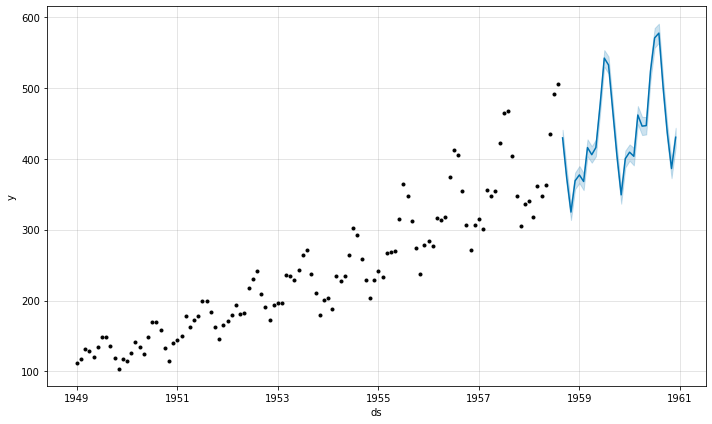

In [139]:
fig1 = model.plot(forecast)

In [142]:
y_pred = forecast[['ds','yhat']]
y_pred['Month'] = pd.to_datetime(y_pred["ds"], infer_datetime_format=True)
y_pred = y_pred.set_index(['Month'])
y_pred = y_pred.drop(['ds'], axis=1)
y_pred.head()

,yhat
Month,
1958-09-01,429.549678
1958-10-01,373.152339
1958-11-01,324.829915
1958-12-01,369.044683
1959-01-01,377.276540


In [145]:
def plot_test_pred(pred, test):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=pd.to_datetime(pred.index.values),
        y=pred['yhat'],
        name='pred'
    ))
    
    fig.add_trace(go.Scatter(
        x=pd.to_datetime(test.index.values),
        y=test['y'],
        name='test'
    )) 
    
    fig.show()
    
plot_test_pred(y_pred,df_proh_test)